## **EDA and Model Training**
#### Imports and configuration

In [2]:
import geopandas as gpd
import pandas as pd
from pickle import dump
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pd.options.mode.chained_assignment = None
base_dir = "C:\\Users\\Chris\\co_cloudcover\\"
label_dir = base_dir + "data\\label\\"
raw_dir = base_dir + "data\\raw\\"
model_dir = base_dir + "models\\"

In [2]:
training_zones = gpd.read_file(label_dir + "training_selection.shp")
training_dates = list(set(training_zones['date']))

IC_202403 = gpd.read_parquet(raw_dir+"ImageCollection_202403.parquet")
IC_202403['date'] = IC_202403['time'].dt.strftime("%Y-%m-%d")

IC_202308 = gpd.read_parquet(raw_dir+"ImageCollection_202308.parquet")
IC_202308['date'] = IC_202308['time'].dt.strftime("%Y-%m-%d")

#### Extract label samples

In [3]:
columns = list(IC_202403.columns)
columns.append("class")
training_data = gpd.GeoDataFrame(data=None, columns=columns)

for zone in training_zones.itertuples():
    temp_IC = IC_202403[IC_202403['date'] == zone[2]]
    temp_IC_training = temp_IC[temp_IC.within(zone[4])]
    temp_IC_training["class"] = zone[3]
    print(f"{len(temp_IC_training)} training samples found in {zone[2]} data")
    training_data = pd.concat([temp_IC_training,training_data])
    
for zone in training_zones.itertuples():
    temp_IC = IC_202308[IC_202308['date'] == zone[2]]
    temp_IC_training = temp_IC[temp_IC.within(zone[4])]
    temp_IC_training["class"] = zone[3]
    print(f"{len(temp_IC_training)} training samples found in {zone[2]} data")
    training_data = pd.concat([temp_IC_training,training_data])

14585 training samples found in 2024-03-14 data


C:\Users\Chris\AppData\Local\Temp\ipykernel_6684\1898981859.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  training_data = pd.concat([temp_IC_training,training_data])


20683 training samples found in 2024-03-14 data
1558 training samples found in 2024-03-28 data
82245 training samples found in 2024-03-01 data
6115 training samples found in 2024-03-01 data
711 training samples found in 2024-03-01 data
4645 training samples found in 2024-03-02 data
17834 training samples found in 2024-03-09 data
5345 training samples found in 2024-03-23 data
0 training samples found in 2023-08-07 data
0 training samples found in 2023-08-13 data
0 training samples found in 2023-08-26 data
0 training samples found in 2023-08-25 data
0 training samples found in 2023-08-25 data
0 training samples found in 2024-03-14 data
0 training samples found in 2024-03-14 data
0 training samples found in 2024-03-28 data
0 training samples found in 2024-03-01 data
0 training samples found in 2024-03-01 data
0 training samples found in 2024-03-01 data
0 training samples found in 2024-03-02 data
0 training samples found in 2024-03-09 data
0 training samples found in 2024-03-23 data
68471 

,time,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b04,sur_refl_b05,sur_refl_b06,sur_refl_b07,geometry,lon,lat,date,class
6884362,2023-08-25,9888.0,9865.0,9631.0,9871.0,7921.0,5400.0,3050.0,POINT (-105.86420 40.94775),-105.864196,40.947751,2023-08-25,cloud
6884759,2023-08-25,9612.0,9582.0,9324.0,9505.0,7843.0,5406.0,3133.0,POINT (-105.85420 40.90775),-105.854196,40.907751,2023-08-25,cloud
6884760,2023-08-25,9513.0,9525.0,9206.0,9494.0,7683.0,5348.0,3164.0,POINT (-105.85420 40.91775),-105.854196,40.917751,2023-08-25,cloud
6884761,2023-08-25,9440.0,9425.0,9185.0,9462.0,7546.0,5130.0,2986.0,POINT (-105.85420 40.92775),-105.854196,40.927751,2023-08-25,cloud
6884762,2023-08-25,9943.0,9886.0,9628.0,9914.0,7797.0,5189.0,2902.0,POINT (-105.85420 40.93775),-105.854196,40.937751,2023-08-25,cloud
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3869362,2024-03-14,8173.0,8165.0,8157.0,8130.0,6393.0,2949.0,1572.0,POINT (-103.82420 38.12775),-103.824196,38.127751,2024-03-14,snow_cloud
3869759,2024-03-14,9720.0,9808.0,9485.0,9654.0,7595.0,3314.0,1670.0,POINT (-103.81420 38.08775),-103.814196,38.087751,2024-03-14,snow_cloud
3869760,2024-03-14,9353.0,9413.0,9145.0,9293.0,7353.0,3244.0,1625.0,POINT (-103.81420 38.09775),-103.814196,38.097751,2024-03-14,snow_cloud
3869761,2024-03-14,9085.0,9134.0,8914.0,9051.0,7138.0,3175.0,1605.0,POINT (-103.81420 38.10775),-103.814196,38.107751,2024-03-14,snow_cloud


In [4]:
features = [
    "sur_refl_b01",
    "sur_refl_b02",
    "sur_refl_b03",
    "sur_refl_b04",
    "sur_refl_b05",
    "sur_refl_b06",
    "sur_refl_b07",
]

X = training_data[features]
y = training_data["class"]

In [5]:
print(set(training_data["class"]))
print(len(training_data[training_data["class"]=="cloud"]) * 0.3)
print(len(training_data[training_data["class"]=="snow_cloud"]) * 0.3)
print(len(training_data[training_data["class"]=="snow"]) * 0.3)
print(len(training_data[training_data["class"]=="terrain"]) * 0.3)

{'snow_cloud', 'terrain', 'snow', 'cloud'}
4721.4
10580.4
7211.099999999999
47049.299999999996


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
rfc = RandomForestClassifier(max_depth=2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9296033811077729


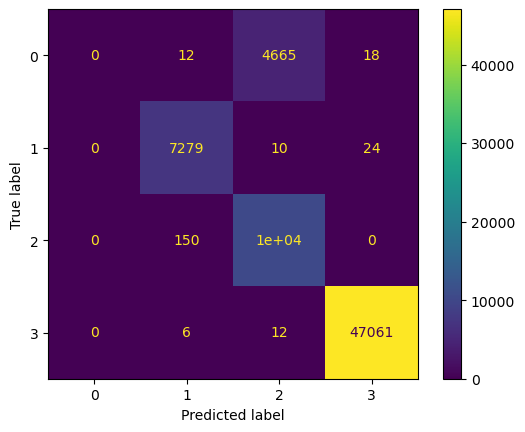

In [9]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();


In [12]:
with open(model_dir + "rfc_20240527.pkl", "wb") as f:
    dump(rfc, f, protocol=5)

<Axes: >

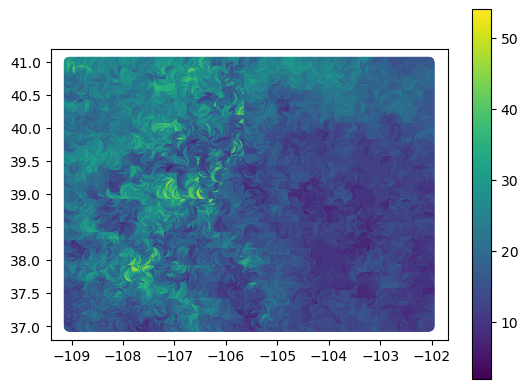

In [ ]:
from pickle import load
with open(model_dir + "rfc_20240527.pkl", "rb") as f:
    rfc1 = load(f)

IC_2022 = gpd.read_parquet(raw_dir+"ImageCollection_2022.parquet")
IC_2022['date'] = IC_2022['time'].dt.strftime("%Y-%m-%d")

IC_2022["prediction"] = rfc1.predict(IC_2022[features])

cloud_count_2022 = IC_2022[IC_2022["prediction"]=="snow_cloud"].\
    groupby(['geometry']).\
    agg("count").\
    reset_index()\
    [["prediction","geometry"]]

gdf = gpd.GeoDataFrame(cloud_count_2022)
gdf.plot(column="clouds",legend=True)